In [11]:
import time
from src.method_selector import MlMethodSelector, ClassicMethodSelector
from src.measurement_provider import MeasurementProvider
from src.serializer import SenMLCBORSerializer, SenMLJSONSerializer
from src.signal_generator import SignalGenerator
from sys import getsizeof
from src.metric import FeatureMetricEnum, SimilarityMetricEnum
from src.data_type import Measurement
import pandas as pd
import matplotlib as plt
from src.metric import SimilarityMetricEnum
import random
plt.rcParams["figure.dpi"] = 150
pd.set_option('display.max_columns', None)

In [12]:
def compute_sizes(dataset, compressed_data, metrics):
  senML_cbor_size_original = getsizeof(SenMLCBORSerializer.serialize(dataset, '/72/', '1/2', metrics))
  senML_cbor_size_compressed = getsizeof(SenMLCBORSerializer.serialize(compressed_data, '/72/', '1/2', metrics))
  senML_cbor_size_diff = senML_cbor_size_original - senML_cbor_size_compressed
  senML_cbor_size_ratio = senML_cbor_size_diff / senML_cbor_size_original

  senML_json_size_original = getsizeof(SenMLJSONSerializer.serialize(dataset, '/72/', '1/2', metrics))
  senML_json_size_compressed = getsizeof(SenMLJSONSerializer.serialize(compressed_data, '/72/', '1/2', metrics))
  senML_json_size_diff = senML_json_size_original - senML_json_size_compressed
  senML_json_size_ratio = senML_json_size_diff / senML_json_size_original
  return {
    'senML_cbor_size_original': senML_cbor_size_original,
    'senML_cbor_size_compressed': senML_cbor_size_compressed,
    'senML_cbor_size_diff': senML_cbor_size_diff,
    'senML_cbor_size_ratio': senML_cbor_size_ratio,

    'senML_json_size_original': senML_json_size_original,
    'senML_json_size_compressed': senML_json_size_compressed,
    'senML_json_size_diff': senML_json_size_diff,
    'senML_json_size_ratio': senML_json_size_ratio,
  }

def current_milis():
  return time.time() * 1000
  
def run_measurements(dataset, get_measurements):
  constraint = {
    SimilarityMetricEnum.compression_rate: 0.5,
    SimilarityMetricEnum.sum_differences: 0.7,
    SimilarityMetricEnum.arithmetic_average: 0.5,
    SimilarityMetricEnum.standard_derivative: 0.5,
    SimilarityMetricEnum.function_field: 0.5,
    SimilarityMetricEnum.diff_of_min: 0.1,
    SimilarityMetricEnum.diff_of_max: 0.1,
    SimilarityMetricEnum.min_max_diff: 0.1,
    # SimilarityMetricEnum.value_crossing: 0.5,
    # SimilarityMetricEnum.positive_value_crossing: 0.5,
    # SimilarityMetricEnum.negative_value_crossing: 0.5,
    # SimilarityMetricEnum.peak_count: 0.5,
    # SimilarityMetricEnum.positive_peak_count: 0.5,
    # SimilarityMetricEnum.negative_peak_count: 0.5,
    SimilarityMetricEnum.median: 0.2,
    SimilarityMetricEnum.covariance: 0.1,
    SimilarityMetricEnum.corelation_pearson: 0.1,
    SimilarityMetricEnum.corelation_spearman: 0.1,
  }
  ml_method_selector = MlMethodSelector()
  ml_method_selector.use_constraint_strategy(constraint)
  ml_method_selector.set_measurements(dataset)
  score = ml_method_selector.train()
  print(score)

  classic_method_selector = ClassicMethodSelector()

  print("datasize,ml_time,classic_time,ml_compressed_size,classic_compressed_size,ml_compression_ratio,classic_compression_ratio,ml_method,classic_method,ml_score,classic_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,classic_cbor_original_size,classic_cbor_compressed_size,classic_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,classic_json_original_size,classic_json_compressed_size,classic_json_compressratio")

  results = {
    "datasize": [],
    "ml_time": [],
    "classic_time": [],
    "ml_compressed_size": [],
    "classic_compressed_size": [],
    "ml_compression_ratio": [],
    "classic_compression_ratio": [],
    "ml_method": [],
    "classic_method": [],
    "ml_score": [],
    "classic_score": [],
    "ml_cbor_original_size": [],
    "ml_cbor_compressed_size": [],
    "ml_cbor_compressratio": [],
    "classic_cbor_original_size": [],
    "classic_cbor_compressed_size": [],
    "classic_cbor_compressratio": [],
    "ml_json_original_size": [],
    "ml_json_compressed_size": [],
    "ml_json_compressratio": [],
    "classic_json_original_size": [],
    "classic_json_compressed_size": [],
    "classic_json_compressratio": [],
  }

  for datasize in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
    measurements = get_measurements(datasize)

    time_start = current_milis()
    compressed_data, stats, metrics = ml_method_selector.compress_with_best(measurements)
    time_end = current_milis()
    serialized_data_stats = compute_sizes(measurements, compressed_data, metrics)
    metrics_score = ClassicMethodSelector().compute_similarity_with_constraint_strategy(measurements, compressed_data, constraint)

    ml_time = time_end - time_start
    ml_compressed_size = stats['compressed_size']
    ml_compression_ratio = stats['compression_rate'] * 100
    ml_method = stats['method_name']
    ml_score = metrics_score
    ml_cbor_original_size = serialized_data_stats['senML_cbor_size_original']
    ml_cbor_compressed_size = serialized_data_stats['senML_cbor_size_compressed']
    ml_cbor_compressratio = serialized_data_stats['senML_cbor_size_ratio']
    ml_json_original_size = serialized_data_stats['senML_json_size_original']
    ml_json_compressed_size = serialized_data_stats['senML_json_size_compressed']
    ml_json_compressratio = serialized_data_stats['senML_json_size_ratio']

    results['datasize'].append(datasize);
    results['ml_time'].append(ml_time);
    results['ml_compressed_size'].append(ml_compressed_size);
    results['ml_compression_ratio'].append(ml_compression_ratio);
    results['ml_method'].append(ml_method);
    results['ml_score'].append(ml_score);
    results['ml_cbor_original_size'].append(ml_cbor_original_size);
    results['ml_cbor_compressed_size'].append(ml_cbor_compressed_size);
    results['ml_cbor_compressratio'].append(ml_cbor_compressratio);
    results['ml_json_original_size'].append(ml_json_original_size);
    results['ml_json_compressed_size'].append(ml_json_compressed_size);
    results['ml_json_compressratio'].append(ml_json_compressratio);

    ##############################################

    time_start = current_milis()
    compressed_data, stats, metrics, metrics_score = classic_method_selector.compress_with_best_constraint_strategy(measurements, constraint)
    time_end = current_milis()
    serialized_data_stats = compute_sizes(measurements, compressed_data, metrics)

    classic_time = time_end - time_start
    classic_compressed_size = stats['compressed_size']
    classic_compression_ratio = stats['compression_rate'] * 100
    classic_method = stats['method_name']
    classic_score = metrics_score
    classic_cbor_original_size = serialized_data_stats['senML_cbor_size_original']
    classic_cbor_compressed_size = serialized_data_stats['senML_cbor_size_compressed']
    classic_cbor_compressratio = serialized_data_stats['senML_cbor_size_ratio']
    classic_json_original_size = serialized_data_stats['senML_json_size_original']
    classic_json_compressed_size = serialized_data_stats['senML_json_size_compressed']
    classic_json_compressratio = serialized_data_stats['senML_json_size_ratio']

    results['classic_time'].append(classic_time);
    results['classic_compressed_size'].append(classic_compressed_size);
    results['classic_compression_ratio'].append(classic_compression_ratio);
    results['classic_method'].append(classic_method);
    results['classic_score'].append(classic_score);
    results['classic_cbor_original_size'].append(classic_cbor_original_size);
    results['classic_cbor_compressed_size'].append(classic_cbor_compressed_size);
    results['classic_cbor_compressratio'].append(classic_cbor_compressratio);
    results['classic_json_original_size'].append(classic_json_original_size);
    results['classic_json_compressed_size'].append(classic_json_compressed_size);
    results['classic_json_compressratio'].append(classic_json_compressratio);

    print(f'{datasize},{ml_time},{classic_time},{ml_compressed_size},{classic_compressed_size},{ml_compression_ratio},{classic_compression_ratio},{ml_method},{classic_method},{ml_score},{classic_score},{ml_cbor_original_size},{ml_cbor_compressed_size},{ml_cbor_compressratio},{classic_cbor_original_size},{classic_cbor_compressed_size},{classic_cbor_compressratio},{ml_json_original_size},{ml_json_compressed_size},{ml_json_compressratio},{classic_json_original_size},{classic_json_compressed_size},{classic_json_compressratio}')
  return pd.DataFrame.from_dict(results)

In [13]:
dataset = MeasurementProvider().get_random3()
df = run_measurements(dataset, lambda datasize: MeasurementProvider().to_measurements(SignalGenerator(0, datasize).linear(2.5).sin(0.3, 0.2)))

(0.4666666666666667, 0.8)
datasize,ml_time,classic_time,ml_compressed_size,classic_compressed_size,ml_compression_ratio,classic_compression_ratio,ml_method,classic_method,ml_score,classic_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,classic_cbor_original_size,classic_cbor_compressed_size,classic_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,classic_json_original_size,classic_json_compressed_size,classic_json_compressratio
100,1.196044921875,86.23291015625,10,10,90.0,90.0,CompressPIP_PD_0.1,CompressPIP_PD_0.1,73.8563,88.6275,2291,493,0.7848101265822784,2291,493,0.7848101265822784,5355,818,0.8472455648926237,5355,818,0.8472455648926237
200,1.48583984375,242.829833984375,21,20,89.5,90.0,CompressNTHS_0.1,CompressPIP_PD_0.1,74.0385,89.2756,4291,713,0.8338382661384293,4291,693,0.8384991843393148,10495,1382,0.8683182467841829,10495,1326,0.8736541210100047
300,2.173828125,467.859130859375,31,30,89.66666666666666,90.0,Compres

In [14]:
# df = pd.read_csv('./results3a.csv')
# df['ml_compression_ratio'] *= 100
# df['classic_compression_ratio'] *= 100

In [15]:
df

,datasize,ml_time,classic_time,ml_compressed_size,classic_compressed_size,ml_compression_ratio,classic_compression_ratio,ml_method,classic_method,ml_score,classic_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,classic_cbor_original_size,classic_cbor_compressed_size,classic_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,classic_json_original_size,classic_json_compressed_size,classic_json_compressratio
0,100,1.196045,86.232910,10,10,90.000000,90.000000,CompressPIP_PD_0.1,CompressPIP_PD_0.1,73.8563,88.6275,2291,493,0.784810,2291,493,0.784810,5355,818,0.847246,5355,818,0.847246
1,200,1.485840,242.829834,21,20,89.500000,90.000000,CompressNTHS_0.1,CompressPIP_PD_0.1,74.0385,89.2756,4291,713,0.833838,4291,693,0.838499,10495,1382,0.868318,10495,1326,0.873654
2,300,2.173828,467.859131,31,30,89.666667,90.000000,CompressNTHS_0.1,CompressPIP_ED_0.1,74.0249,88.0781,6292,913,0.854895,6292,893,0.858074,15598,1908,0.877677,15583,1845,0.881602
3,400,2.684570,766.963135,41,41,89.750000,89.750000,CompressNTHS_0.1,CompressNTHS_0.1,74.3916,89.2699,8292,1113,0.865774,8292,1113,0.865774,20675,2406,0.883628,20675,2406,0.883628
4,500,3.519043,1107.070312,51,50,89.800000,90.000000,CompressNTHS_0.1,CompressPIP_ED_0.1,74.2645,88.1732,10292,1313,0.872425,10292,1293,0.874368,25847,2918,0.887105,25845,2865,0.889147
5,600,3.883057,1610.919189,61,61,89.833333,89.833333,CompressNTHS_0.1,CompressNTHS_0.1,74.2320,89.0784,12292,1513,0.876912,12292,1513,0.876912,31039,3447,0.888946,31039,3447,0.888946
6,700,4.391113,2046.794922,71,71,89.857143,89.857143,CompressNTHS_0.1,CompressNTHS_0.1,74.4980,89.3976,14380,1723,0.880181,14380,1723,0.880181,36215,3964,0.890543,36215,3964,0.890543
7,800,5.027100,2566.547852,81,81,89.875000,89.875000,CompressNTHS_0.1,CompressNTHS_0.1,74.2479,89.0975,16580,1943,0.882811,16580,1943,0.882811,41389,4482,0.891710,41389,4482,0.891710
8,900,5.512939,3312.003174,91,91,89.888889,89.888889,CompressNTHS_0.1,CompressNTHS_0.1,74.3669,89.2403,18780,2163,0.884824,18780,2163,0.884824,46549,4998,0.892629,46549,4998,0.892629
9,1000,6.089844,3991.687256,101,101,89.900000,89.900000,CompressNTHS_0.1,CompressNTHS_0.1,74.4986,89.3983,20980,2383,0.886416,20980,2383,0.886416,51675,5499,0.893585,51675,5499,0.893585


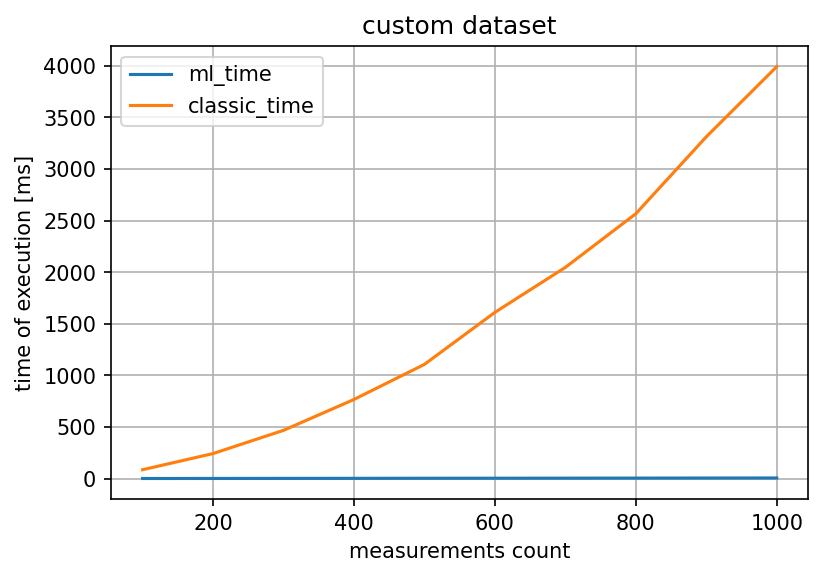

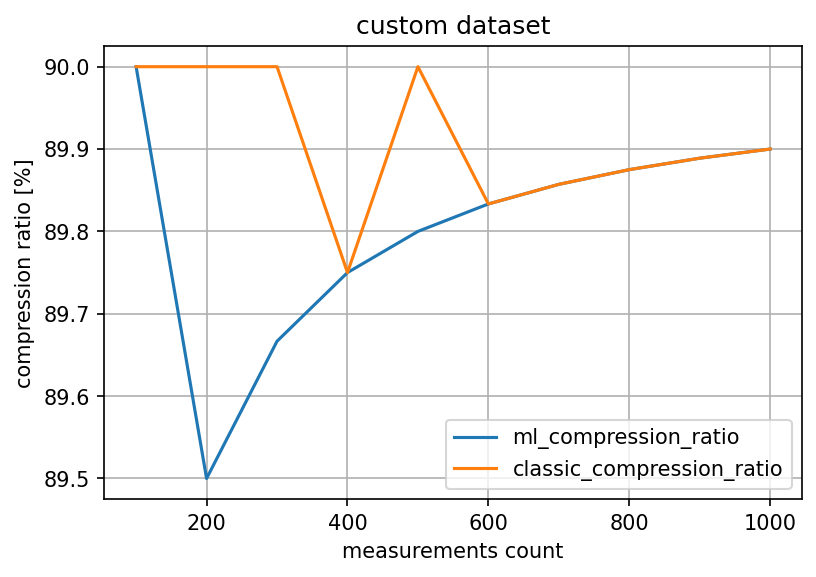

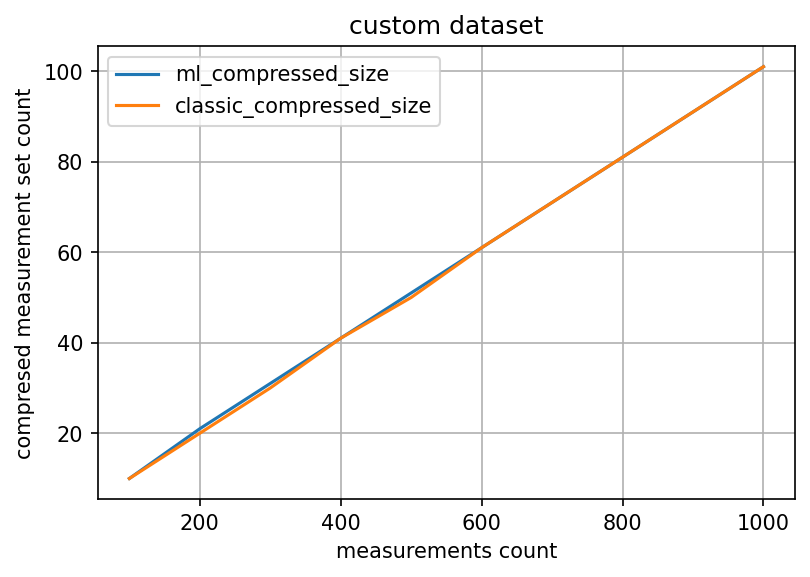

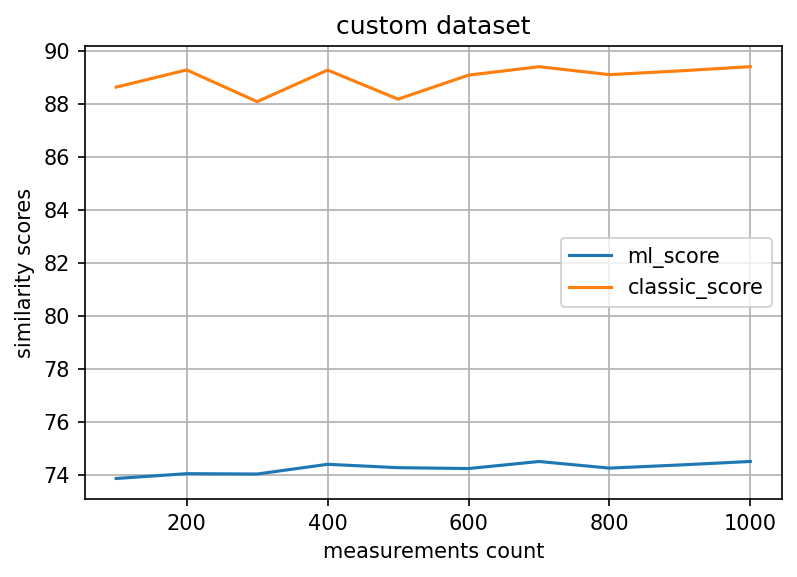

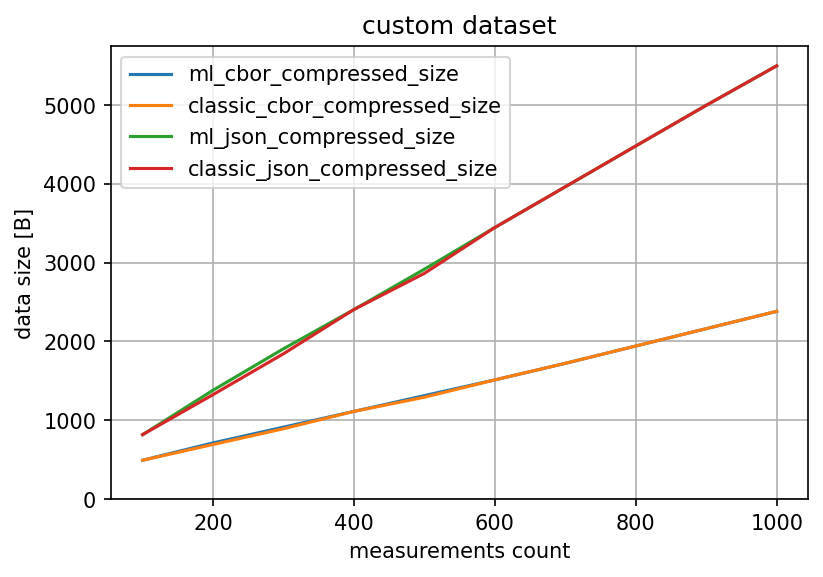

In [16]:
path = '../plot/strategy3'
ax = df.plot(x='datasize', y=['ml_time', 'classic_time'], grid=True)
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("time of execution [ms]")
ax.figure.savefig(f'{path}/1a.png')

ax = df.plot(x='datasize', y=['ml_compression_ratio', 'classic_compression_ratio'], grid=True)
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("compression ratio [%]")
ax.figure.savefig(f'{path}/2a.png')

ax = df.plot(x='datasize', y=['ml_compressed_size', 'classic_compressed_size'], grid=True)
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("compresed measurement set count")
ax.figure.savefig(f'{path}/3a.png')

ax = df.plot(x='datasize', y=['ml_score', 'classic_score'], grid=True)
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("similarity scores")
ax.figure.savefig(f'{path}/4a.png')

ax = df.plot(x='datasize', y=['ml_cbor_compressed_size', 'classic_cbor_compressed_size', 'ml_json_compressed_size', 'classic_json_compressed_size'], grid=True, ylim=0)
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("data size [B]")
ax.figure.savefig(f'{path}/5a.png')


In [43]:
measurements1 = MeasurementProvider().json_to_measurements('stock1.json')
size1 = len(measurements1)
dataset = []
for i in range(10):
  start = int(random.randint(0, size1) * 0.7)
  end = random.randint(start, size1)
  dataset.append(measurements1[start:end])
df = run_measurements(dataset, lambda datasize: MeasurementProvider().json_to_measurements('stock1.json')[:datasize])

(0.5, 0.5)
datasize,ml_time,classic_time,ml_compressed_size,classic_compressed_size,ml_compression_ratio,classic_compression_ratio,ml_method,classic_method,ml_score,classic_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,classic_cbor_original_size,classic_cbor_compressed_size,classic_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,classic_json_original_size,classic_json_compressed_size,classic_json_compressratio
100,0.875,87.119140625,11,10,89.0,90.0,CompressNTHS_0.1,CompressPIP_PD_0.1,72.9843,88.9505,2521,563,0.7766759222530741,2521,541,0.7854026180087267,5773,1001,0.82660661701022,5743,913,0.841023855127982
200,1.54931640625,241.00390625,21,20,89.5,90.0,CompressNTHS_0.1,CompressPIP_PD_0.1,100,88.3368,4721,783,0.8341453081974158,4721,761,0.83880533785215,11185,1531,0.8631202503352704,11148,1434,0.871367061356297
300,2.18505859375,435.998779296875,31,30,89.66666666666666,90.0,CompressNTHS_0.1,CompressPIP_PD_0.1,72.8123,88

In [44]:
# df = pd.read_csv('./results3b.csv')
# df['ml_compression_ratio'] *= 100
# df['classic_compression_ratio'] *= 100

In [45]:
df

,datasize,ml_time,classic_time,ml_compressed_size,classic_compressed_size,ml_compression_ratio,classic_compression_ratio,ml_method,classic_method,ml_score,classic_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,classic_cbor_original_size,classic_cbor_compressed_size,classic_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,classic_json_original_size,classic_json_compressed_size,classic_json_compressratio
0,100,0.875000,87.119141,11,10,89.000000,90.00,CompressNTHS_0.1,CompressPIP_PD_0.1,72.9843,88.9505,2521,563,0.776676,2521,541,0.785403,5773,1001,0.826607,5743,913,0.841024
1,200,1.549316,241.003906,21,20,89.500000,90.00,CompressNTHS_0.1,CompressPIP_PD_0.1,100.0000,88.3368,4721,783,0.834145,4721,761,0.838805,11185,1531,0.863120,11148,1434,0.871367
2,300,2.185059,435.998779,31,30,89.666667,90.00,CompressNTHS_0.1,CompressPIP_PD_0.1,72.8123,88.1334,6922,1003,0.855100,6922,981,0.858278,16618,2081,0.874774,16543,1947,0.882307
3,400,2.681152,708.099121,41,41,89.750000,89.75,CompressNTHS_0.1,CompressNTHS_0.1,74.3190,89.1828,9122,1223,0.865929,9122,1223,0.865929,22028,2609,0.881560,22028,2609,0.881560
4,500,3.477295,974.718018,51,49,89.800000,90.20,CompressNTHS_0.1,CompressPAAVI_0.1,73.8098,84.9689,11322,1443,0.872549,11322,1591,0.859477,27436,3128,0.885989,27450,3142,0.885537
5,600,3.900391,1415.112305,61,60,89.833333,90.00,CompressNTHS_0.1,CompressPIP_PD_0.1,100.0000,90.3092,13522,1663,0.877015,13522,1641,0.878642,32960,3726,0.886954,32900,3615,0.890122
6,700,4.620117,1786.484131,71,70,89.857143,90.00,CompressNTHS_0.1,CompressPIP_PD_0.1,74.1661,89.9352,15722,1883,0.880232,15722,1861,0.881631,38385,4268,0.888811,38323,4157,0.891527
7,800,5.416992,2177.634033,81,80,89.875000,90.00,CompressNTHS_0.1,CompressPIP_ED_0.1,100.0000,90.3748,17922,2103,0.882658,17922,2081,0.883886,43763,4781,0.890752,43705,4670,0.893147
8,900,5.929199,2818.955078,91,90,89.888889,90.00,CompressNTHS_0.1,CompressPIP_PD_0.1,100.0000,90.6823,20122,2323,0.884554,20122,2301,0.885648,49313,5361,0.891286,49224,5218,0.893995
9,1000,6.286865,3340.054199,101,100,89.900000,90.00,CompressNTHS_0.1,CompressPIP_PD_0.1,100.0000,89.8559,22322,2543,0.886077,22322,2521,0.887062,54850,5905,0.892343,54770,5771,0.894632


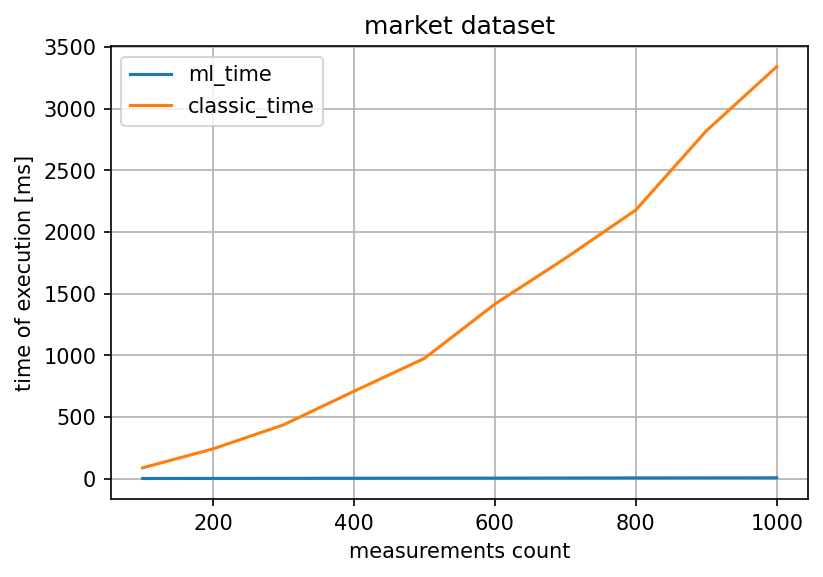

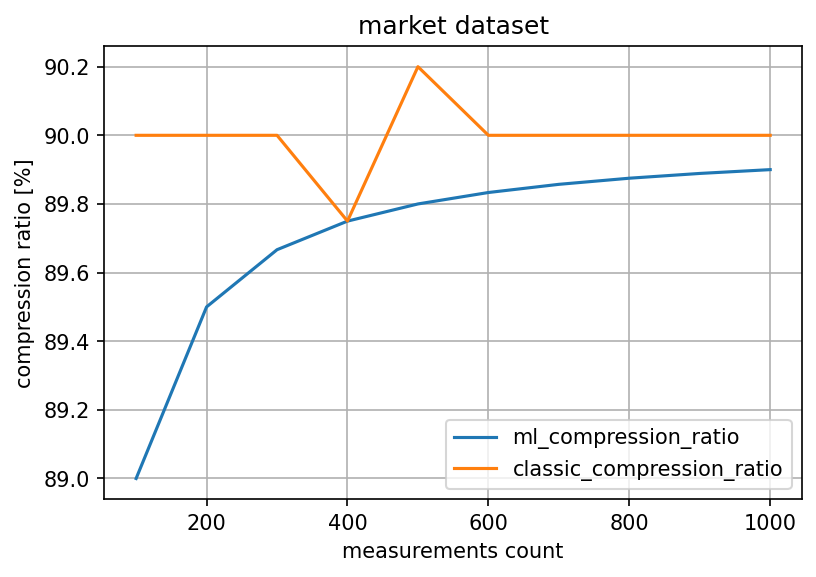

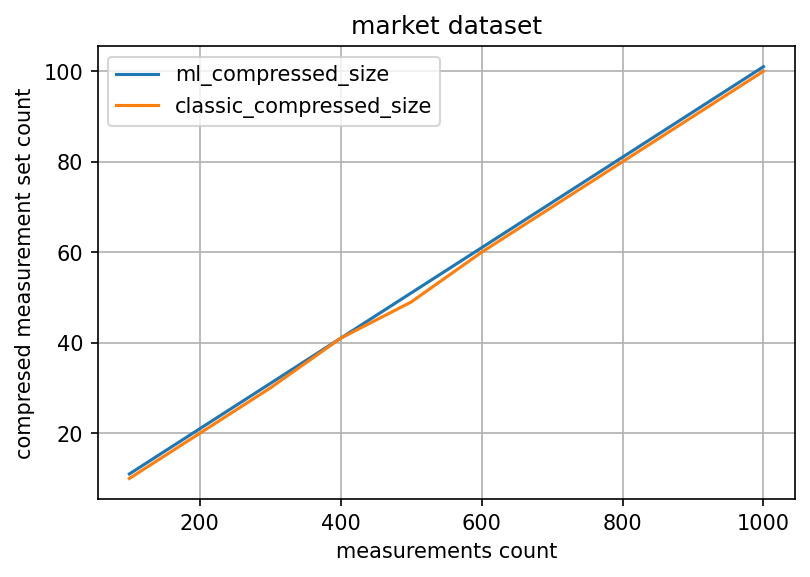

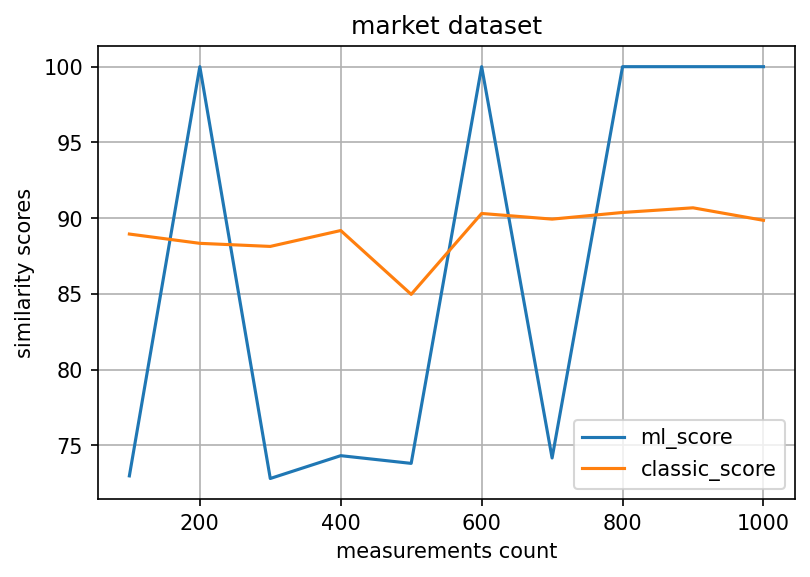

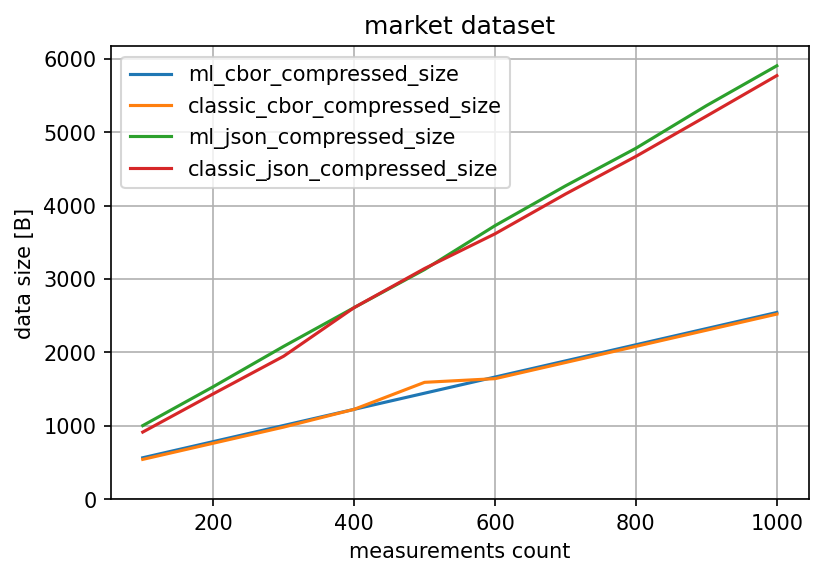

In [46]:
path = '../plot/strategy3'
ax = df.plot(x='datasize', y=['ml_time', 'classic_time'], grid=True)
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("time of execution [ms]")
ax.figure.savefig(f'{path}/1b.png')

ax = df.plot(x='datasize', y=['ml_compression_ratio', 'classic_compression_ratio'], grid=True)
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("compression ratio [%]")
ax.figure.savefig(f'{path}/2b.png')

ax = df.plot(x='datasize', y=['ml_compressed_size', 'classic_compressed_size'], grid=True)
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("compresed measurement set count")
ax.figure.savefig(f'{path}/3b.png')

ax = df.plot(x='datasize', y=['ml_score', 'classic_score'], grid=True)
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("similarity scores")
ax.figure.savefig(f'{path}/4b.png')

ax = df.plot(x='datasize', y=['ml_cbor_compressed_size', 'classic_cbor_compressed_size', 'ml_json_compressed_size', 'classic_json_compressed_size'], grid=True, ylim=0)
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("data size [B]")
ax.figure.savefig(f'{path}/5b.png')
